In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap.umap_ as umap
import os

In [17]:
csv_path = "/Users/franciscomagot/Documents/Code/ml/p2/feature_vectors/csv_data/"
feature_vectors_path = "/Users/franciscomagot/Documents/Code/ml/p2/feature_vectors/numpy_data/"
model_name = "r21d/"
model_version = "r2plus1d_34_32_ig65m_ft_kinetics"

# Loading and Visualization of features

In [3]:
path1 = csv_path + "train_data_" + model_version + ".csv"

train_data = pd.read_csv(path1)
train_data = train_data.rename(columns={'0.1': 'label'})

train_data.head()

,youtube_id,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,label
0,nHTC03tkqJE,0.258363,0.121080,0.083454,0.413967,0.207141,0.814762,0.467885,0.016713,1.937834,...,1.280350,1.167866,1.644562,0.702157,0.737276,1.176710,1.565002,0.231098,0.365090,shot put
1,wDWWMsBb5Jk,1.115174,1.102532,0.026706,0.543923,0.550062,1.290800,0.368735,0.398212,0.674873,...,0.916569,1.984999,0.423220,0.329978,1.456248,1.437892,0.464151,0.487795,1.215269,fixing hair
2,GiOmBE2gZB8,1.478772,0.575591,0.668397,0.298991,0.269182,1.099690,0.343764,0.316514,1.330548,...,1.225618,0.745292,0.233769,1.868962,0.880948,1.792181,0.074164,0.546215,1.263791,fixing hair
3,uLCjKfT1quw,0.842914,0.730823,0.007088,0.893789,0.165128,1.002654,0.991852,0.883051,2.371499,...,0.724554,2.481772,0.042083,0.318964,1.912350,1.127336,0.011937,0.336436,1.194232,fixing hair
4,MHIEhrMq1A4,0.459295,1.082993,0.206227,0.981999,0.845415,1.421666,0.359727,0.115920,1.787516,...,0.508368,2.016125,0.427951,0.242765,0.897486,1.000751,0.245629,0.085206,1.498395,dying hair


In [4]:
def plot_dim_reduction(data, method='umap', title='Dimensionality Reduction'):
    # Standardizing the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.drop(['label', 'youtube_id'], axis=1))

    # Apply UMAP or t-SNE
    if method == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        raise ValueError("Invalid method. Choose 'umap' or 'tsne'.")

    reduced_data = reducer.fit_transform(scaled_data)

    # Color mapping for labels
    unique_labels = data['label'].unique()
    color_map = {label: idx for idx, label in enumerate(unique_labels)}
    label_indices = [color_map[label] for label in data['label']]

    # Plotting
    plt.figure(figsize=(12, 9))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=label_indices, cmap='gist_rainbow', edgecolors='k', alpha=0.7)

    # Create a legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.gist_rainbow(color_map[label] / len(unique_labels)), markersize=10, label=label) for label in unique_labels]
    plt.legend(handles=legend_elements, title="Labels")

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'{title} ({method.upper()})')
    plt.show()


/Users/franciscomagot/Documents/Code/ml/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/franciscomagot/Documents/Code/ml/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


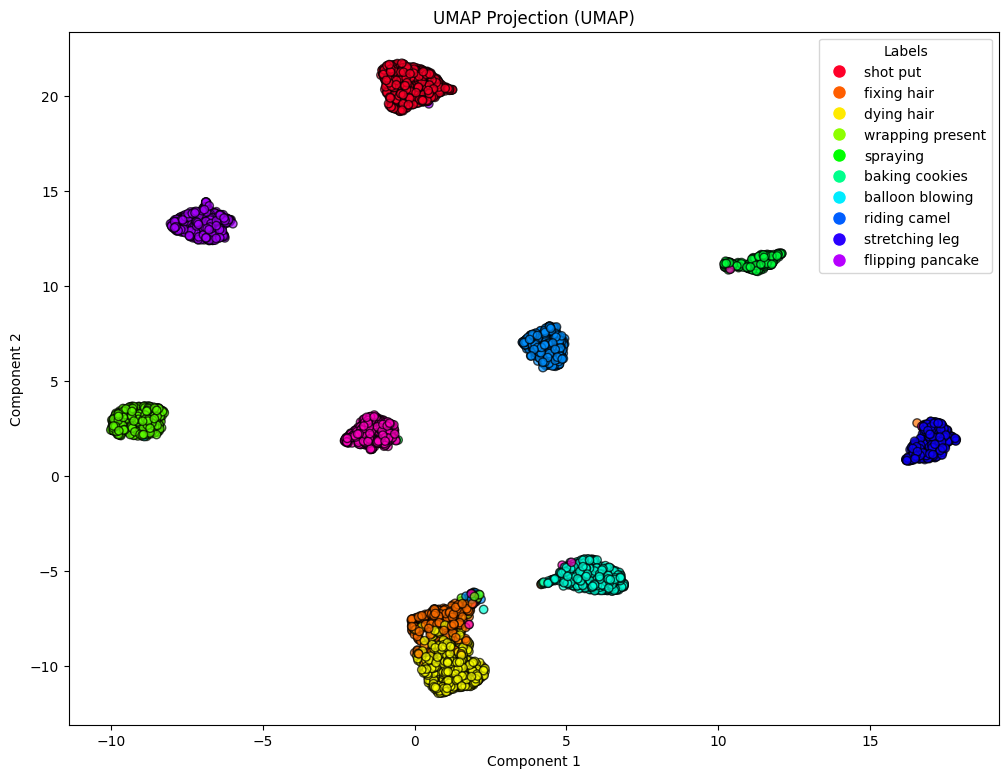

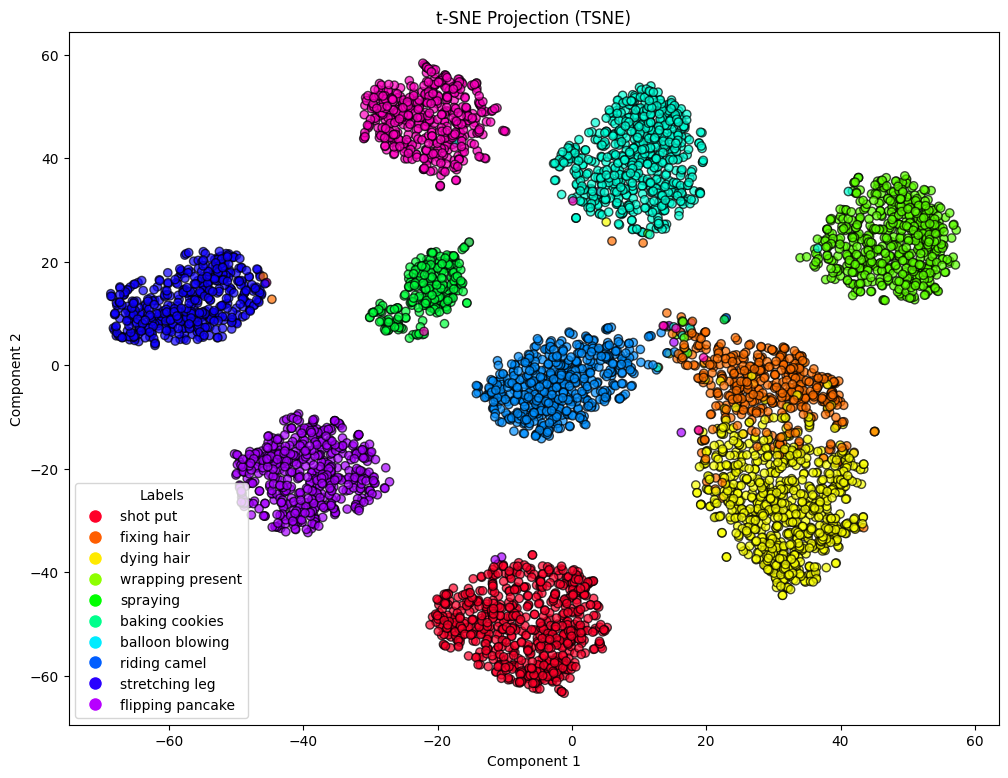

In [8]:
plot_dim_reduction(train_data, method='umap', title='UMAP Projection')
plot_dim_reduction(train_data, method='tsne', title='t-SNE Projection')

# Implementation of Clustering methods

### K-means++

In [9]:
class KMeans_PP:
    def __init__(self, data, k=3):
        self.data = data
        self.k = k
        self.assignment = [-1 for i in range(len(data))]
        self.history = []

    def euclidean_dist(self, x, y):
        return np.sqrt(np.sum((x - y) ** 2))

    def kmeans_plus_plus(self):
        centroids = self.data[np.random.choice(len(self.data), size=1)]

        for _ in range(1, self.k):
            min_sq_dist = np.array([
                min(self.euclidean_dist(c, p) ** 2 for c in centroids)
                for p in self.data
            ])

            probability = min_sq_dist / min_sq_dist.sum()

            new_centroid = self.data[np.random.choice(len(self.data), size=1, p=probability)]
            centroids = np.vstack([centroids, new_centroid])

        return centroids


    def unassigned(self, i):
        return self.assignment[i] == -1

    def assign(self, cent):
            for i in range(len(self.data)):
                min_dist = float('inf')
                for j in range(self.k):
                    dist = self.euclidean_dist(self.data[i], cent[j])
                    if self.unassigned(i) or dist < min_dist:
                        self.assignment[i] = j
                        min_dist = dist

    def snap(self, centers):
        self.history.append(np.copy(centers))

    def update_centers(self):
        centers = []
        for j in range(self.k):
            cluster = np.array([self.data[i] for i in range(len(self.data)) if self.assignment[i] == j])

            if cluster.size == 0:
                centers.append(self.data[np.random.randint(len(self.data))])
            else:
                centers.append(np.mean(cluster, axis=0))

        return np.array(centers)

    def centers_diff(self, c1, c2):
        for i in range(self.k):
            if self.euclidean_dist(c1[i], c2[i]) != 0:
                return True
        return False

    def unassign_all(self):
        self.assignment = [-1 for _ in range(len(self.data))]

    def fit(self):
        centers = self.kmeans_plus_plus()
        self.assign(centers)
        self.snap(centers)
        new_centers = self.update_centers()

        while self.centers_diff(centers, new_centers):
            self.unassign_all()
            centers = new_centers
            self.assign(centers)
            self.snap(centers)
            new_centers = self.update_centers()

    def predict(self, test_data):
        pred = []
        for point in test_data:
            min_dist = float('inf')
            assigned_cluster = -1
            for j in range(self.k):
                dist = self.euclidean_dist(point, self.history[-1][j])
                if dist < min_dist:
                    min_dist = dist
                    assigned_cluster = j
            pred.append(assigned_cluster)
        return pred

### DBSCAN

In [10]:
class DBSCAN:
    def __init__(self, data, eps=0.5, min_samples=11):
        self.data = data
        self.eps = eps
        self.min_samples = min_samples
        self.labels = [-1] * len(data)  # Inicialmente, todos son considerados ruido (-1)
        self.cluster_id = 0

    def euclidean_dist(self, x, y):
        return np.sqrt(np.sum((x - y) ** 2))

    def region_query(self, point_idx):
        neighbors = []
        for i in range(len(self.data)):
            if self.euclidean_dist(self.data[point_idx], self.data[i]) <= self.eps:
                neighbors.append(i)
        return neighbors

    def expand_cluster(self, point_idx, neighbors):
        self.labels[point_idx] = self.cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            if self.labels[neighbor_idx] == -1:
                self.labels[neighbor_idx] = self.cluster_id
            elif self.labels[neighbor_idx] == -2:
                self.labels[neighbor_idx] = self.cluster_id
                new_neighbors = self.region_query(neighbor_idx)
                if len(new_neighbors) >= self.min_samples:
                    neighbors += new_neighbors
            i += 1

    def fit(self):
        self.labels = [-2] * len(self.data)

        for point_idx in range(len(self.data)):
            if self.labels[point_idx] != -2:
                continue

            neighbors = self.region_query(point_idx)

            if len(neighbors) < self.min_samples:
                self.labels[point_idx] = -1
            else:
                self.expand_cluster(point_idx, neighbors)
                self.cluster_id += 1

    def predict(self, test_data):
        predictions = []
        for point in test_data:
            min_dist = float('inf')
            assigned_cluster = -1
            for cluster_id in range(self.cluster_id):
                cluster_points = [self.data[i] for i in range(len(self.labels)) if self.labels[i] == cluster_id]
                for cp in cluster_points:
                    dist = self.euclidean_dist(point, cp)
                    if dist < min_dist:
                        min_dist = dist
                        assigned_cluster = cluster_id
            predictions.append(assigned_cluster if min_dist <= self.eps else -1)
        return predictions


# Experimentation

### K-means++

In [ ]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap
import numpy as np
import pandas as pd

# Load dataset
path1 = csv_path + "train_data_" + model_version + ".csv"
train_data = pd.read_csv(path1)
train_data = train_data.rename(columns={'0.1': 'label'})

# Extract features and labels
X = train_data.iloc[:, 1:-1].values  # Exclude 'youtube_id' and 'label'
y_true = train_data['label'].astype('category').cat.codes  # Convert labels to numerical values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Experiment with different reduction methods and components
reduction_methods = ['umap', 'tsne']
n_components_list = [2, 3, 4, 5, 6]
k = 10

for reduction_method in reduction_methods:
    for n_components in n_components_list:
        print(f"\nUsing {reduction_method.upper()} with {n_components} components")
        
        if reduction_method == 'umap':
            reducer = umap.UMAP(n_components=n_components, random_state=42)
        elif reduction_method == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=42, perplexity=30)
        else:
            raise ValueError("Invalid reduction method. Choose 'umap' or 'tsne'.")

        X_reduced = reducer.fit_transform(X_scaled)

        # Train KMeans++ model
        model = KMeans_PP(X_reduced, k)
        model.fit()

        # Get cluster assignments
        y_pred = model.assignment

        # Compute clustering metrics
        silhouette = silhouette_score(X_reduced, y_pred)
        rand_index = adjusted_rand_score(y_true, y_pred)
        mutual_info = normalized_mutual_info_score(y_true, y_pred)

        # Print results
        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Adjusted Rand Index: {rand_index:.4f}")
        print(f"Normalized Mutual Information Score: {mutual_info:.4f}")


In [ ]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import numpy as np
import pandas as pd

# Load dataset
path1 = csv_path + "train_data_" + model_version + ".csv"
train_data = pd.read_csv(path1)
train_data = train_data.rename(columns={'0.1': 'label'})

# Extract features and labels
X = train_data.iloc[:, 1:-1].values  # Exclude 'youtube_id' and 'label'
y_true = train_data['label'].astype('category').cat.codes  # Convert labels to numerical values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP for dimensionality reduction
n_components = 5
reducer = umap.UMAP(n_components=n_components, random_state=42)
X_reduced = reducer.fit_transform(X_scaled)

# Experiment with different values of k
k_values = range(8, 12)

for k in k_values:
    print(f"\nClustering with K={k}")
    
    # Train KMeans++ model
    model = KMeans_PP(X_reduced, k)
    model.fit()
    
    # Get cluster assignments
    y_pred = model.assignment
    
    # Compute clustering metrics
    silhouette = silhouette_score(X_reduced, y_pred)
    rand_index = adjusted_rand_score(y_true, y_pred)
    mutual_info = normalized_mutual_info_score(y_true, y_pred)

In [32]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
path1 = csv_path + "train_data_" + model_version + ".csv"
train_data = pd.read_csv(path1)
train_data = train_data.rename(columns={'0.1': 'label'})

# Extract features and labels
X = train_data.iloc[:, 1:-1].values  # Exclude 'youtube_id' and 'label'
y_true = train_data['label'].astype('category').cat.codes  # Convert labels to numerical values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP for dimensionality reduction
n_components = 5
reducer = umap.UMAP(n_components=n_components, random_state=42)
X_reduced = reducer.fit_transform(X_scaled)

# Experiment with different values of k
k_values = range(8, 12)
silhouette_scores = []
rand_indices = []
mutual_infos = []

for k in k_values:
    print(f"\nClustering with K={k}")
    
    # Train KMeans++ model
    model = KMeans_PP(X_reduced, k)
    model.fit()
    
    # Get cluster assignments
    y_pred = model.assignment
    
    # Compute clustering metrics
    silhouette = silhouette_score(X_reduced, y_pred)
    rand_index = adjusted_rand_score(y_true, y_pred)
    mutual_info = normalized_mutual_info_score(y_true, y_pred)
    
    # Store metrics
    silhouette_scores.append(silhouette)
    rand_indices.append(rand_index)
    mutual_infos.append(mutual_info)

/Users/franciscomagot/Documents/Code/ml/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/franciscomagot/Documents/Code/ml/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Clustering with K=8

Clustering with K=9

Clustering with K=10

Clustering with K=11


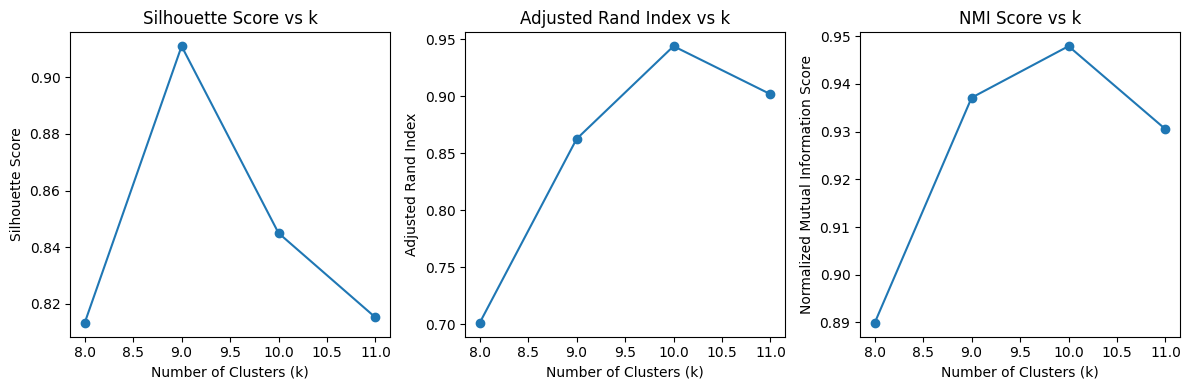

In [33]:
# Plot metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')

plt.subplot(1, 3, 2)
plt.plot(k_values, rand_indices, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Adjusted Rand Index')
plt.title('Adjusted Rand Index vs k')

plt.subplot(1, 3, 3)
plt.plot(k_values, mutual_infos, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Normalized Mutual Information Score')
plt.title('NMI Score vs k')

plt.tight_layout()
plt.show()

### DBSCAN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

path1 = csv_path + "train_data_" + model_version + ".csv"

train_data = pd.read_csv(path1)
train_data = train_data.rename(columns={'0.1': 'label'})

# Extract features and labels
X = train_data.iloc[:, 1:-1].values  # Exclude 'youtube_id' and 'label'
y_true = train_data['label'].astype('category').cat.codes  # Convert labels to numerical values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Experiment settings
reduction_methods = ['umap', 'tsne']
n_components_list = [2, 3, 4, 5, 6]

# Store results
results = {method: {'n_components': [], 'silhouette': [], 'rand_index': [], 'mutual_info': []} for method in reduction_methods}

for reduction_method in reduction_methods:
    for n_components in n_components_list:
        print(f"\nUsing {reduction_method.upper()} with {n_components} components")

        # Apply dimensionality reduction
        if reduction_method == 'umap':
            reducer = umap.UMAP(n_components=n_components, random_state=42)
        elif reduction_method == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=42, perplexity=30)

        else:
            raise ValueError("Invalid reduction method. Choose 'umap' or 'tsne'.")

        X_reduced = reducer.fit_transform(X_scaled)

        # Apply DBSCAN clustering
        eps = 0.5
        min_samples = 11
        model = DBSCAN(eps=eps, min_samples=min_samples)
        y_pred = model.fit_predict(X_reduced)

        # Compute clustering metrics (ignoring noise points)
        valid_indices = y_pred != -1
        if np.sum(valid_indices) > 1:
            silhouette = silhouette_score(X_reduced[valid_indices], y_pred[valid_indices])
            rand_index = adjusted_rand_score(y_true[valid_indices], y_pred[valid_indices])
            mutual_info = normalized_mutual_info_score(y_true[valid_indices], y_pred[valid_indices])
        else:
            silhouette, rand_index, mutual_info = -1, -1, -1

        # Store results
        results[reduction_method]['n_components'].append(n_components)
        results[reduction_method]['silhouette'].append(silhouette)
        results[reduction_method]['rand_index'].append(rand_index)
        results[reduction_method]['mutual_info'].append(mutual_info)


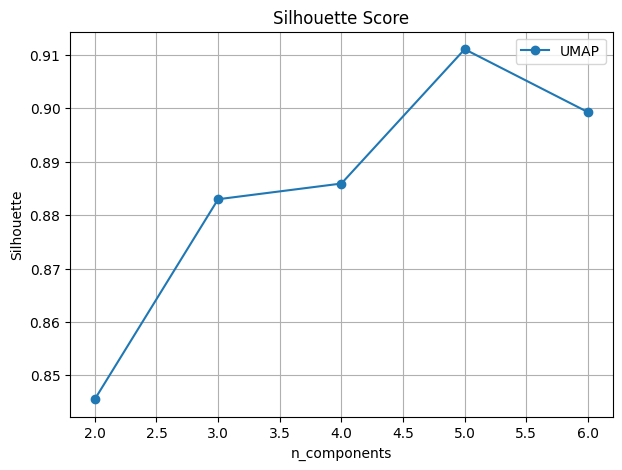

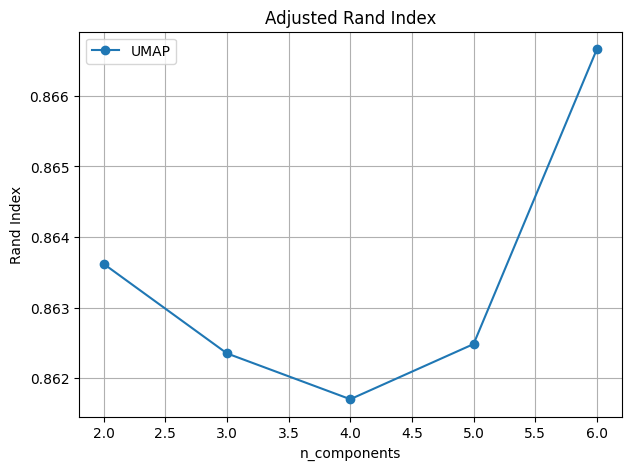

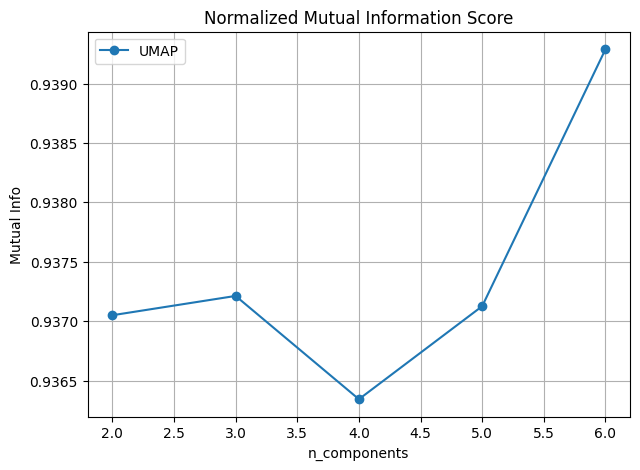

In [28]:
import matplotlib.pyplot as plt

umap_results = results['umap']

# Metrics and titles
metrics = ['silhouette', 'rand_index', 'mutual_info']
titles = ['Silhouette Score', 'Adjusted Rand Index', 'Normalized Mutual Information Score']

# Function to plot UMAP metrics
def plot_umap_metric(metric, title):
    plt.figure(figsize=(7, 5))
    plt.plot(umap_results['n_components'], umap_results[metric], marker='o', label='UMAP')
    plt.title(title)
    plt.xlabel('n_components')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate plots
for metric, title in zip(metrics, titles):
    plot_umap_metric(metric, title)

In [34]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Load dataset
path1 = csv_path + "train_data_" + model_version + ".csv"
train_data = pd.read_csv(path1)
train_data = train_data.rename(columns={'0.1': 'label'})

# Extract features and labels
X = train_data.iloc[:, 1:-1].values  # Exclude 'youtube_id' and 'label'
y_true = train_data['label'].astype('category').cat.codes  # Convert labels to numerical values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP for dimensionality reduction
n_components = 5
reducer = umap.UMAP(n_components=n_components, random_state=42)
X_reduced = reducer.fit_transform(X_scaled)

# Experiment with different values of eps
eps_values = [0.3, 0.5, 0.7, 0.9]
min_samples = 11
silhouette_scores = []
rand_indices = []
mutual_infos = []

for eps in eps_values:
    print(f"\nClustering with eps={eps}")
    
    # Train DBSCAN model
    model = DBSCAN(eps=eps, min_samples=min_samples)
    y_pred = model.fit_predict(X_reduced)
    
    # Compute clustering metrics (ignoring noise points)
    valid_indices = y_pred != -1
    if np.sum(valid_indices) > 1:
        silhouette = silhouette_score(X_reduced[valid_indices], y_pred[valid_indices])
        rand_index = adjusted_rand_score(y_true[valid_indices], y_pred[valid_indices])
        mutual_info = normalized_mutual_info_score(y_true[valid_indices], y_pred[valid_indices])
    else:
        silhouette, rand_index, mutual_info = -1, -1, -1
    
    # Store metrics
    silhouette_scores.append(silhouette)
    rand_indices.append(rand_index)
    mutual_infos.append(mutual_info)

/Users/franciscomagot/Documents/Code/ml/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/franciscomagot/Documents/Code/ml/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Clustering with eps=0.3

Clustering with eps=0.5

Clustering with eps=0.7

Clustering with eps=0.9


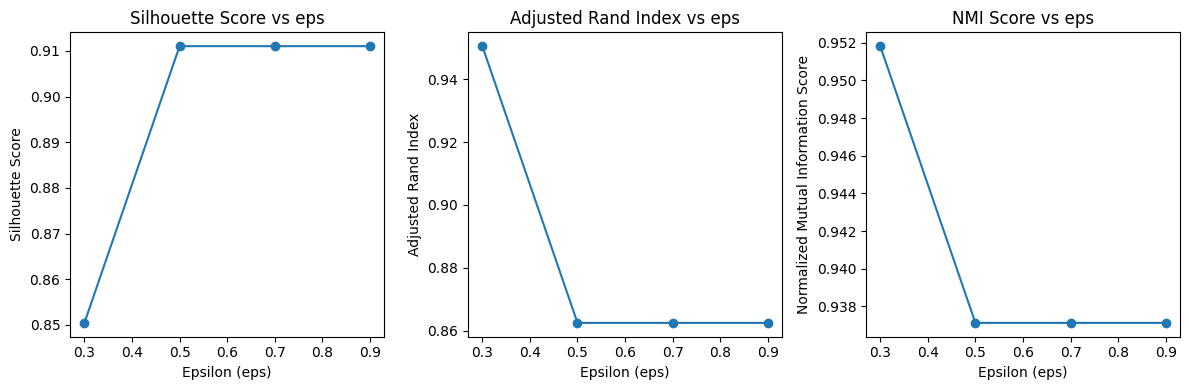

In [35]:
# Plot metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(eps_values, silhouette_scores, marker='o')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs eps')

plt.subplot(1, 3, 2)
plt.plot(eps_values, rand_indices, marker='o')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Adjusted Rand Index')
plt.title('Adjusted Rand Index vs eps')

plt.subplot(1, 3, 3)
plt.plot(eps_values, mutual_infos, marker='o')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Normalized Mutual Information Score')
plt.title('NMI Score vs eps')

plt.tight_layout()
plt.show()

### Experimentation best results

| Métrica                    | Mejor Método de Clustering  | Mejor Número de Componentes (reducción de dimensionalidad) | Mejor Método | Mejor Valor     |
|----------------------------|----------------|----------------------------|----------------------------|-----------------|
| **Silhouette Score**        | DBSCAN           | 5                          | UMAP                    | 0.9111          |
| **Rand Index**    | K-means++           | 6                          | UMAP                    | 0.9460          |
| **Mutual Information** | K-means++     | 6                          | UMAP                    | 0.9479          |


In [36]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap
import numpy as np

path2 = csv_path + "test_data_" + model_version + ".csv"
train_data = pd.read_csv(path2)
train_data = train_data.rename(columns={'0.1': 'label'})  # Renaming columns if needed

# Extract features and labels
X = train_data.iloc[:, 1:-1].values  # Exclude 'youtube_id' and 'label'
y_true = train_data['label'].astype('category').cat.codes  # Convert labels to numerical values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Experiment with different reduction methods and components
reduction_method = 'umap'
n_components = 5
k = 10  # Number of clusters

# Prepare to save the results
output_results = []

if reduction_method == 'umap':
    reducer = umap.UMAP(n_components=n_components, random_state=42)
elif reduction_method == 'tsne':
    reducer = TSNE(n_components=n_components, random_state=42, perplexity=30)
else:
    raise ValueError("Invalid reduction method. Choose 'umap' or 'tsne'.")

X_reduced = reducer.fit_transform(X_scaled)

# Train KMeans++ model
model = KMeans_PP(X_reduced, k)
model.fit()

# Get cluster assignments
y_pred = model.assignment

# Collect results for output
for youtube_id, label in zip(train_data['youtube_id'], y_pred):
    output_results.append([youtube_id, label])

# Save clustering results to CSV
output_df = pd.DataFrame(output_results, columns=['youtube_id', 'label'])
output_path = "clustering_results.csv"  # Specify the path where the CSV should be saved
output_df.to_csv(output_path, index=False)

print(f"Clustering results saved to {output_path}")

/Users/franciscomagot/Documents/Code/ml/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/franciscomagot/Documents/Code/ml/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clustering results saved to clustering_results.csv
